In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
last_date_str = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
last_date = (dt.datetime.strptime(last_date_str, "%Y-%m-%d")).date()
last_date

datetime.date(2017, 8, 23)

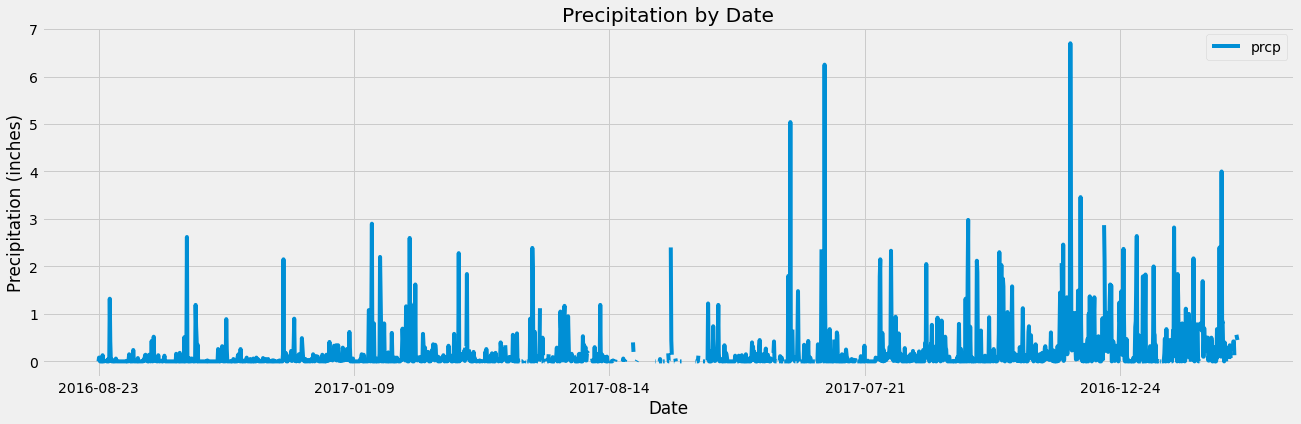

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_year = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(measurement.date, measurement.prcp).\
            filter((measurement.date >= last_year)\
                    & (measurement.date <= last_date)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.DataFrame(prcp_data).set_index("date")

# Sort the dataframe by date
df_prcp.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
df_prcp.plot(figsize=(20,6))
plt.title("Precipitation by Date")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)");

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station).count()
station_count

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                  order_by(func.count(measurement.station).desc()).\
                  group_by(measurement.station).\
                  all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]

low_temp = session.query(func.min(measurement.tobs)).\
            filter(measurement.station == most_active).scalar()

high_temp = session.query(func.max(measurement.tobs)).\
            filter(measurement.station == most_active).scalar()

avg_temp = session.query(func.max(measurement.tobs)).\
            filter(measurement.station == most_active).scalar()

print(f'''Most active station: {most_active}
Lowest temperature: {low_temp} °F
Highest temperature: {high_temp} °F
Average temperature: {avg_temp} °F''')

Most active station: USC00519281
Lowest temperature: 54.0 °F
Highest temperature: 85.0 °F
Average temperature: 85.0 °F


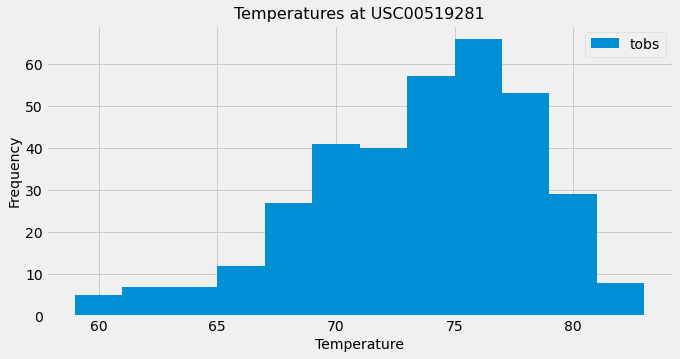

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df_most_active = pd.DataFrame(session.query(measurement.tobs).\
                                filter((measurement.station == most_active)\
                                        & (measurement.date >= last_year)\
                                        & (measurement.date <= last_date)).all())

df_most_active.plot(kind="hist", figsize=(10,5), bins=12, legend=True)
plt.xticks()
plt.yticks()
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title(f"Temperatures at {most_active}", fontsize=16);

# Close session

In [21]:
# Close Session
session.close()